# Settings

In [1]:
EXP_NO = 3
SEED = 1
N_SPLITS = 5
CV = 'StratifiedKFold'
TARGET = 'target'
GROUP = 'art_series_id'

# Library

In [2]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_lightning import seed_everything
import seaborn as sns
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.dirname(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from folder import experiment_dir_of
from dataset import load_csvfiles, load_photofiles, AtmaImageDatasetV01
from models import AutoEncoderV01

In [3]:
pd.options.display.float_format = '{:.5f}'.format

# Prepare directory

In [4]:
output_dir = experiment_dir_of(EXP_NO)

In [5]:
output_dir

'..\\scripts\\..\\experiments\\exp003'

# Prepare logger

In [6]:
logger = getLogger(__name__)

In [7]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [8]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: {}'.format(CV))
logger.info('SEED: {}'.format(SEED))

2021-07-15 21:28:30,901 - __main__ - INFO - Experiment no: 3
2021-07-15 21:28:30,904 - __main__ - INFO - CV: StratifiedKFold
2021-07-15 21:28:30,905 - __main__ - INFO - SEED: 1


# Load csv files

In [9]:
SINCE = time.time()

In [10]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-15 21:28:30,934 - __main__ - DEBUG - Start loading csv files (0.017 seconds passed)
2021-07-15 21:28:30,996 - __main__ - DEBUG - Complete loading csv files (0.079 seconds passed)


In [11]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [12]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Feature extraction by autoencoder

## Train autoencoder

Refference:  
https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1  
https://www.guruguru.science/competitions/17/discussions/e926a5a6-78fd-4bdf-87ff-d08fbff25a02/

In [13]:
EPOCHS = 100
BATCH_SIZE = 512

In [14]:
logger.debug('Train autoencoder ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-15 21:28:31,060 - __main__ - DEBUG - Train autoencoder (0.143 seconds passed)


In [15]:
seed_everything(SEED)

Global seed set to 1


1

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
object_ids = train['object_id'].tolist() + test['object_id'].tolist()
dataset = AtmaImageDatasetV01(object_ids)

In [18]:
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

In [19]:
model = AutoEncoderV01().to(device)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [21]:
metrics = []
model_path = os.path.join(output_dir, 'model_state.torch')
best_loss = np.inf
for epoch in range(EPOCHS):
    logger.debug("Epoch {}/{} start".format(epoch + 1, EPOCHS))
    metrics_ = []
    for batch in dataloader:
        batch = batch.to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        batch_flattened, encoded, reconstructed = model(batch)
        
        # compute training reconstruction loss
        loss = criterion(batch_flattened, reconstructed)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        metrics_.append(loss.to('cpu').detach().numpy().copy())
    
    # compute the epoch training loss
    loss = np.mean(metrics_)
    
    # display the epoch training loss
    logger.debug("Epoch {}/{} complete: loss = {:.6f}".format(epoch + 1, EPOCHS, loss))
    
    metrics.append(loss)
    
    if loss < best_loss:
        best_loss = loss
        logger.debug('Metrics improved: {:.6f} -> {:.6f}'.format(loss, best_loss))
        torch.save(model.state_dict(), model_path)

2021-07-15 21:28:31,271 - __main__ - DEBUG - Epoch 1/100 start
2021-07-15 21:28:58,939 - __main__ - DEBUG - Epoch 1/100 complete: loss = 599.161682
2021-07-15 21:28:58,939 - __main__ - DEBUG - Metrics improved: 599.161682 -> 599.161682
2021-07-15 21:28:59,043 - __main__ - DEBUG - Epoch 2/100 start
2021-07-15 21:29:24,194 - __main__ - DEBUG - Epoch 2/100 complete: loss = 21.652622
2021-07-15 21:29:24,194 - __main__ - DEBUG - Metrics improved: 21.652622 -> 21.652622
2021-07-15 21:29:24,317 - __main__ - DEBUG - Epoch 3/100 start
2021-07-15 21:29:49,591 - __main__ - DEBUG - Epoch 3/100 complete: loss = 1.716247
2021-07-15 21:29:49,591 - __main__ - DEBUG - Metrics improved: 1.716247 -> 1.716247
2021-07-15 21:29:49,694 - __main__ - DEBUG - Epoch 4/100 start
2021-07-15 21:30:15,179 - __main__ - DEBUG - Epoch 4/100 complete: loss = 0.698574
2021-07-15 21:30:15,179 - __main__ - DEBUG - Metrics improved: 0.698574 -> 0.698574
2021-07-15 21:30:15,286 - __main__ - DEBUG - Epoch 5/100 start
2021-07-

2021-07-15 21:43:46,572 - __main__ - DEBUG - Metrics improved: 0.029980 -> 0.029980
2021-07-15 21:43:46,694 - __main__ - DEBUG - Epoch 37/100 start
2021-07-15 21:44:11,943 - __main__ - DEBUG - Epoch 37/100 complete: loss = 0.028090
2021-07-15 21:44:11,943 - __main__ - DEBUG - Metrics improved: 0.028090 -> 0.028090
2021-07-15 21:44:12,053 - __main__ - DEBUG - Epoch 38/100 start
2021-07-15 21:44:37,450 - __main__ - DEBUG - Epoch 38/100 complete: loss = 0.026448
2021-07-15 21:44:37,450 - __main__ - DEBUG - Metrics improved: 0.026448 -> 0.026448
2021-07-15 21:44:37,545 - __main__ - DEBUG - Epoch 39/100 start
2021-07-15 21:45:02,789 - __main__ - DEBUG - Epoch 39/100 complete: loss = 0.025019
2021-07-15 21:45:02,789 - __main__ - DEBUG - Metrics improved: 0.025019 -> 0.025019
2021-07-15 21:45:02,907 - __main__ - DEBUG - Epoch 40/100 start
2021-07-15 21:45:28,242 - __main__ - DEBUG - Epoch 40/100 complete: loss = 0.023774
2021-07-15 21:45:28,242 - __main__ - DEBUG - Metrics improved: 0.023774 

2021-07-15 22:00:13,941 - __main__ - DEBUG - Epoch 76/100 start
2021-07-15 22:00:39,316 - __main__ - DEBUG - Epoch 76/100 complete: loss = 1.506881
2021-07-15 22:00:39,316 - __main__ - DEBUG - Epoch 77/100 start
2021-07-15 22:01:04,443 - __main__ - DEBUG - Epoch 77/100 complete: loss = 1.951867
2021-07-15 22:01:04,443 - __main__ - DEBUG - Epoch 78/100 start
2021-07-15 22:01:29,602 - __main__ - DEBUG - Epoch 78/100 complete: loss = 2.920853
2021-07-15 22:01:29,602 - __main__ - DEBUG - Epoch 79/100 start
2021-07-15 22:01:54,825 - __main__ - DEBUG - Epoch 79/100 complete: loss = 2.437445
2021-07-15 22:01:54,825 - __main__ - DEBUG - Epoch 80/100 start
2021-07-15 22:02:19,879 - __main__ - DEBUG - Epoch 80/100 complete: loss = 2.213026
2021-07-15 22:02:19,879 - __main__ - DEBUG - Epoch 81/100 start
2021-07-15 22:02:44,834 - __main__ - DEBUG - Epoch 81/100 complete: loss = 2.392545
2021-07-15 22:02:44,834 - __main__ - DEBUG - Epoch 82/100 start
2021-07-15 22:03:09,980 - __main__ - DEBUG - Epo

In [22]:
np.save(os.path.join(output_dir, 'autoencoder_metrics'), np.array(metrics))

In [23]:
del model, batch
gc.collect()

32

## Feature extraction

In [24]:
feature_extractor = AutoEncoderV01()
feature_extractor.load_state_dict(torch.load(model_path))
feature_extractor.eval()

AutoEncoderV01(
  (encoder): Sequential(
    (0): Linear(in_features=150528, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=150528, bias=True)
  )
)

In [25]:
%%time
images = load_photofiles(object_ids)

Wall time: 14.8 s


In [26]:
%%time
images = torch.from_numpy(images).type(torch.FloatTensor).to(device)

Wall time: 758 ms


In [27]:
%%time
with torch.no_grad():
    _, features, _ = feature_extractor(images)

Wall time: 29.5 s


In [28]:
del _, feature_extractor
gc.collect()

568

In [29]:
features = features.to('cpu').detach().numpy().copy()

In [30]:
features.shape

(9856, 64)

In [31]:
features = pd.DataFrame(data=features, index=object_ids)
features

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
002bff09b09998d0be65,6.02342,6.03538,-6.29166,6.09582,-6.63066,-6.29910,-6.26897,-6.22625,-6.34322,-6.37667,...,-6.17740,6.59218,-5.99844,-6.34549,6.20194,6.24396,6.30331,-6.27070,-6.46921,6.43648
00309fb1ef05416f9c1f,4.71163,4.79944,-4.97370,4.79243,-5.22997,-5.00007,-4.87673,-4.91137,-5.01472,-5.02607,...,-4.84375,5.17189,-4.74816,-5.00026,4.91912,4.91728,4.99318,-4.90027,-5.11544,5.12447
003a1562e97f79ba96dc,6.95182,7.06783,-7.34767,7.08926,-7.70432,-7.35349,-7.24841,-7.24969,-7.40431,-7.41507,...,-7.19515,7.64209,-7.02728,-7.35022,7.17197,7.23841,7.35748,-7.29294,-7.53361,7.50927
004890880e8e7431147b,6.61670,6.66414,-6.97066,6.70351,-7.33669,-7.00060,-6.84257,-6.83445,-6.97711,-7.03149,...,-6.82821,7.25377,-6.61397,-6.93663,6.74997,6.83376,6.94486,-6.89892,-7.11248,7.12903
00718c32602425f504c1,6.34380,6.43173,-6.67485,6.43222,-7.02094,-6.69404,-6.54063,-6.63774,-6.78988,-6.68474,...,-6.51852,6.97555,-6.38942,-6.73712,6.51352,6.62985,6.69154,-6.57067,-6.84308,6.85030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbe65ad399b632dcbd0,6.05175,6.11740,-6.37339,6.14629,-6.69496,-6.38666,-6.30279,-6.26159,-6.44378,-6.40852,...,-6.24618,6.62519,-6.13225,-6.35555,6.22296,6.28315,6.37095,-6.30695,-6.51919,6.54305
ffd7b2d646c0320c311a,6.32570,6.54714,-6.76076,6.58601,-7.10817,-6.80362,-6.65212,-6.66384,-6.82759,-6.80831,...,-6.62203,7.05994,-6.53526,-6.77721,6.64991,6.73637,6.83355,-6.73508,-6.90117,6.95371
ffdb93ede17d4501e530,6.14850,6.18295,-6.43857,6.23233,-6.76942,-6.54331,-6.38327,-6.40903,-6.49309,-6.49412,...,-6.31906,6.74580,-6.18386,-6.48356,6.32764,6.34051,6.48582,-6.41988,-6.70148,6.68402
ffe111402004b0ed46b4,5.83720,5.92062,-6.17265,5.94226,-6.50685,-6.16867,-6.04055,-6.05118,-6.23462,-6.27985,...,-6.05633,6.45545,-5.89324,-6.19115,5.96416,6.03884,6.10827,-6.05250,-6.24504,6.39660


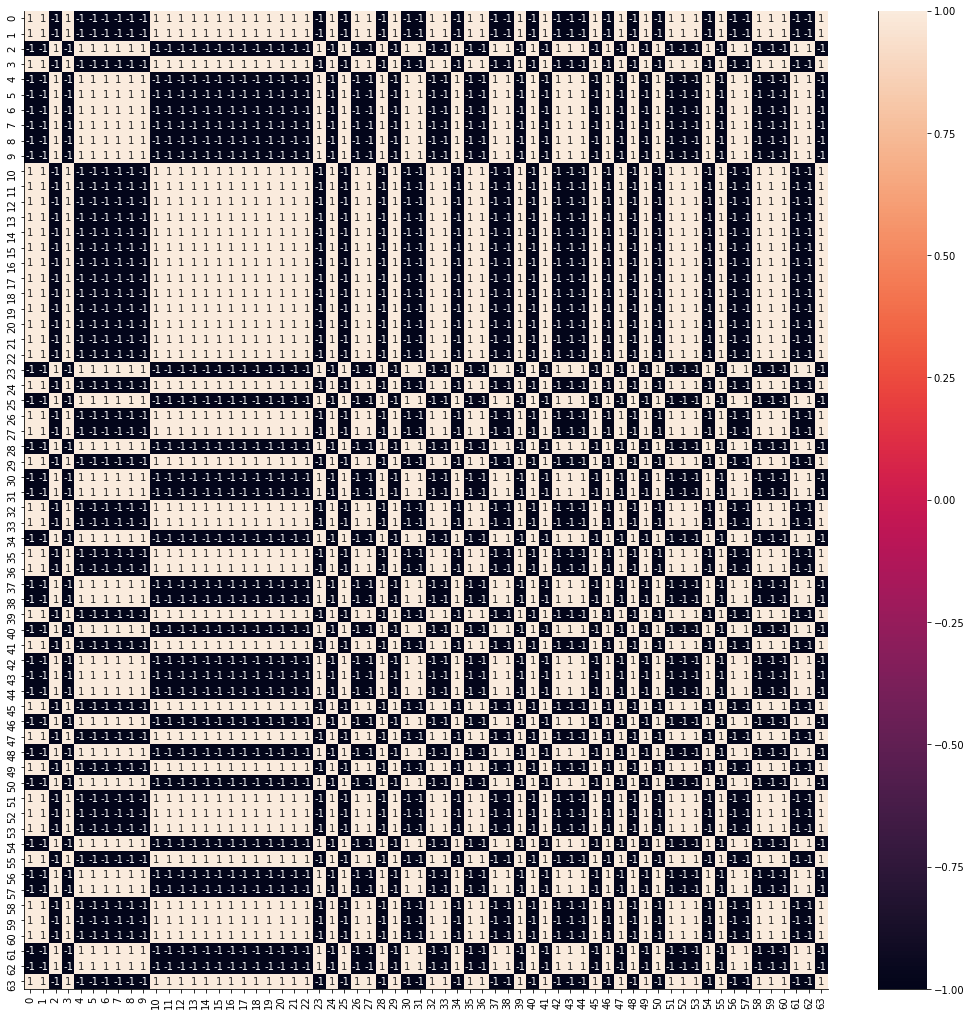

In [32]:
plt.figure(figsize=(18., 18.))
sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True)
sns.despine()

In [33]:
features.to_csv(os.path.join(output_dir, 'features.csv'))

# Cross validation

In [34]:
# Splitter
if CV == 'GroupKFold':
    splitter = GroupKFold(n_splits=5)
    fold_indice = splitter.split(X=train, y=train[TARGET], groups=train[GROUP])
elif CV == 'StratifiedKFold':
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_indice = splitter.split(X=train, y=train[TARGET])
else:
    raise ValueError(CV)

In [35]:
# %%time
# # Load and flatten test set images
# logger.debug('Start loading test images ({:.3f} seconds passed)'.format(time.time() - SINCE))
# test_images = load_photofiles(test['object_id'])
# logger.debug('Complete loading test images ({:.3f} seconds passed)'.format(time.time() - SINCE))
# test_images = test_images.reshape(test_images.shape[0], -1)

In [36]:
for i, (train_index, valid_index) in enumerate(fold_indice):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))
    # Separate dataset into training/validation fold
#     train_index = train_index[:500]
    id_train = train.iloc[train_index]['object_id']
    X_train = features.loc[id_train]
    y_train = train.iloc[train_index][TARGET]
    id_valid = train.iloc[valid_index]['object_id']
    X_valid = features.loc[id_valid]
    y_valid = train.iloc[valid_index][TARGET]
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = RidgeClassifierCV(alphas=(0.1, 1.0, 10.0, 100.0, 500., 1000.),
                                  class_weight='balanced',
                                  normalize=True)
    estimator.fit(X_train, y_train)
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Training set
    pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                              columns=estimator.classes_)
    pred_train['object_id'] = id_train.values
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                              columns=estimator.classes_)
    pred_valid['object_id'] = id_valid.values
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    X_test = features.loc[test['object_id']]
    pred_test = pd.DataFrame(data=estimator.decision_function(X_test.copy()),
                             columns=estimator.classes_)
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pickle')
    with open(filepath_fold_model, 'wb') as f:
        model = [estimator, ]
        pickle.dump(model, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (model, estimator, X_train, X_valid, y_train, y_valid,
         pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-15 22:11:38,767 - __main__ - DEBUG - Start fold 1 (2587.849 seconds passed)
2021-07-15 22:11:38,776 - __main__ - DEBUG - Start training model (2587.859 seconds passed)
2021-07-15 22:11:38,827 - __main__ - DEBUG - Complete training (2587.910 seconds passed)
2021-07-15 22:11:38,854 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp003\cv_fold1_training.csv (2587.936 seconds passed)
2021-07-15 22:11:38,866 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp003\cv_fold1_validation.csv (2587.948 seconds passed)
2021-07-15 22:11:38,921 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp003\cv_fold1_test.csv (2588.003 seconds passed)
2021-07-15 22:11:38,927 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp003\cv_fold1_model.pickle (2588.009 seconds passed)
2021-07-15 22:11:39,185 - __main__ - DEBUG - Complete fold 1 (2588.268 seconds passed)
2021-07-15 22:11:39,185 - __main__ - DEBUG - Start fold 2 (2588.268 seco

# Evaluation

In [37]:
rmse = partial(mean_squared_error, squared=False)

In [38]:
qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [39]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [40]:
assert(train['object_id'].duplicated().sum() == 0)
train.set_index('object_id', inplace=True)

In [41]:
metrics = defaultdict(list)

## Training set

In [42]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                    pred_train_df['2'], pred_train_df['3'])
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                           labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
    score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
    logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
    metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-15 22:11:40,041 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-15 22:11:40,089 - __main__ - DEBUG - Loss: 1.1026974057972498
2021-07-15 22:11:40,090 - __main__ - DEBUG - Score: 0.005456432221489282
2021-07-15 22:11:40,091 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-15 22:11:40,129 - __main__ - DEBUG - Loss: 1.2359081833978505
2021-07-15 22:11:40,129 - __main__ - DEBUG - Score: 0.04927656418452908
2021-07-15 22:11:40,130 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-15 22:11:40,167 - __main__ - DEBUG - Loss: 1.1066896153673371
2021-07-15 22:11:40,168 - __main__ - DEBUG - Score: 0.002252683836587055
2021-07-15 22:11:40,168 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-15 22:11:40,205 - __main__ - DEBUG - Loss: 1.2292725943057183
2021-07-15 22:11:40,205 - __main__ - DEBUG - Score: 0.0924993381672845
2021-07-15 22:11:40,206 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2

[[  0 159 221   0]
 [  0 307 409   0]
 [  0 461 747   1]
 [  0 357 487   0]]
[[ 28   6 213 133]
 [ 22  25 408 262]
 [ 39  35 737 397]
 [ 16  20 465 343]]
[[  1 160 219   0]
 [  0 311 406   0]
 [  0 467 741   1]
 [  0 368 476   0]]
[[ 50  27 209  94]
 [ 61  57 410 189]
 [ 93  61 735 320]
 [ 50  37 473 284]]
[[ 23 135 205  17]
 [ 18 256 409  34]
 [ 32 361 745  71]
 [ 29 290 475  50]]


In [43]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
pred_train

,0,1,2,3,pred,actual
object_id,,,,,,
002bff09b09998d0be65,-0.40105,-0.40151,-0.39568,-0.40176,2,1
00309fb1ef05416f9c1f,-0.39201,-0.37973,-0.44611,-0.38215,1,3
003a1562e97f79ba96dc,-0.40747,-0.41783,-0.35849,-0.41621,2,3
004890880e8e7431147b,-0.40622,-0.41109,-0.37157,-0.41112,2,2
00718c32602425f504c1,-0.40282,-0.40702,-0.38481,-0.40535,2,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,-0.40062,-0.39861,-0.40210,-0.39867,1,3
ffd4d361756587883e48,-0.39724,-0.39433,-0.41204,-0.39639,1,1
ffd794b7b311b7b7fd92,-0.39513,-0.38993,-0.42539,-0.38954,3,2


In [44]:
print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
logger.info('Training score: {}'.format(score))

2021-07-15 22:11:40,317 - __main__ - INFO - Training loss: 1.1564223599642776
2021-07-15 22:11:40,318 - __main__ - INFO - Training score: 0.05453658173022824


[[ 22 109 267  77]
 [ 12 237 512 135]
 [ 28 316 928 239]
 [ 17 229 595 214]]


In [45]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-15 22:11:40,352 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp003\prediction_train.csv


## Validation set

In [46]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                    pred_valid_df['2'], pred_valid_df['3'])
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                           labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
    score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
    logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
    metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-15 22:11:40,375 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-15 22:11:40,395 - __main__ - DEBUG - Loss: 1.1089163320431714
2021-07-15 22:11:40,396 - __main__ - DEBUG - Score: 0.018151238028618177
2021-07-15 22:11:40,397 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-15 22:11:40,418 - __main__ - DEBUG - Loss: 1.2513951604971694
2021-07-15 22:11:40,418 - __main__ - DEBUG - Score: -0.022021357100815653
2021-07-15 22:11:40,419 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-15 22:11:40,439 - __main__ - DEBUG - Loss: 1.0928902729303704
2021-07-15 22:11:40,440 - __main__ - DEBUG - Score: 0.02601061700827878
2021-07-15 22:11:40,440 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-15 22:11:40,459 - __main__ - DEBUG - Loss: 1.2906663271270657
2021-07-15 22:11:40,460 - __main__ - DEBUG - Score: 0.0028298467649573444
2021-07-15 22:11:40,461 - __main__ - DEBUG - Evaluate cv result (validation

[[  0  50  45   0]
 [  0  84  96   0]
 [  0 126 176   0]
 [  0 102 109   0]]
[[  0   4  57  34]
 [  4   5 107  63]
 [  9   6 191  97]
 [  4   7 130  70]]
[[  0  45  50   0]
 [  0  77 102   0]
 [  0 115 187   0]
 [  0  89 122   0]]
[[  8   3  54  30]
 [ 14   9  99  57]
 [ 23  14 185  80]
 [ 15  11 116  69]]
[[  3  26  60   6]
 [  5  59 103  12]
 [  6  99 184  13]
 [  9  69 119  14]]


In [47]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
pred_valid

,0,1,2,3,pred,actual
object_id,,,,,,
002bff09b09998d0be65,-0.10005,-0.10013,-0.09973,-0.10009,2,1
00309fb1ef05416f9c1f,-0.09641,-0.09603,-0.11178,-0.09578,3,3
003a1562e97f79ba96dc,-0.10328,-0.10333,-0.08954,-0.10384,2,3
004890880e8e7431147b,-0.10268,-0.10191,-0.09266,-0.10275,2,2
00718c32602425f504c1,-0.10141,-0.10303,-0.09395,-0.10161,2,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,-0.10043,-0.09968,-0.10046,-0.09943,3,3
ffd4d361756587883e48,-0.09868,-0.09867,-0.10388,-0.09877,1,1
ffd794b7b311b7b7fd92,-0.09779,-0.09819,-0.10665,-0.09737,3,2


In [48]:
print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
logger.info('Validatino score: {}'.format(score))

2021-07-15 22:11:40,557 - __main__ - INFO - Validatino loss: 1.1864530396697675
2021-07-15 22:11:40,558 - __main__ - INFO - Validatino score: -0.0016624246039576018


[[ 11 128 266  70]
 [ 23 234 507 132]
 [ 38 360 923 190]
 [ 28 278 596 153]]


In [49]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-15 22:11:40,606 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp003\prediction_valid.csv


In [50]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-15 22:11:40,626 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp003\metrics.json


# Prediction

In [51]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [52]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,0,1,2,3,pred
object_id,,,,,
0009e50b94be36ccad39,-0.48294,-0.46783,-0.58047,-0.46876,1
000bd5e82eb22f199f44,-0.47812,-0.45850,-0.60563,-0.45774,3
0015f44de1854f617516,-0.50740,-0.50879,-0.47245,-0.51136,2
00388a678879ba1efa27,-0.50966,-0.52143,-0.44850,-0.52040,2
005e1e7c6496902d23f3,-0.49387,-0.48908,-0.52912,-0.48793,3
...,...,...,...,...,...
ffbe65ad399b632dcbd0,-0.50110,-0.50365,-0.49309,-0.50216,2
ffd7b2d646c0320c311a,-0.50559,-0.50986,-0.47445,-0.51011,2
ffdb93ede17d4501e530,-0.50368,-0.50278,-0.48782,-0.50573,2


In [53]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1
1,3
2,2
3,2
4,3
...,...
5914,2
5915,2
5916,2
5917,3


In [54]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [55]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-15 22:11:40,830 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp003\003_submission.csv


2021-07-15 22:11:40,895 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp003\prediction.png


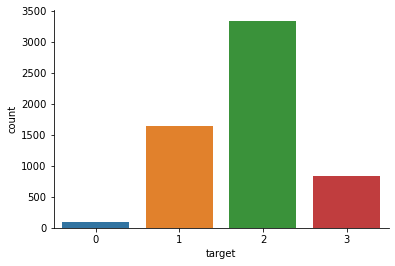

In [56]:
fig = plt.figure()
sns.countplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [57]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-15 22:11:40,948 - __main__ - DEBUG - Complete (2590.030 seconds passed)
